In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import os
import tempfile
import time
import pickle
import pandas as pd
import numpy as np
from scipy import signal
from sklearn.model_selection import train_test_split    # for creating data set 
from sklearn.preprocessing import StandardScaler   # data strandardization
from sklearn.preprocessing import MinMaxScaler    # for daa  normalization
from sklearn.preprocessing import scale
import keras
from keras.utils.np_utils import to_categorical  
from sklearn import model_selection
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn import decomposition
from keras.models import Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D,MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation, GaussianNoise, LSTM , GlobalAveragePooling2D
from sklearn.metrics import accuracy_score
from keras.layers import concatenate ,Add, TimeDistributed
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from keras import backend
import tensorflow as tf
from tensorflow.python import keras
from IPython.display import Image

# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

# Load only 22/32 participants with frontal videos recorded
files = []
for n in range(1, 23): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)

labels = []
rawdata = []

for i in files: 
  filename = "/content/drive/MyDrive/dataset/data_preprocessed_python/s" + i + ".dat"
  trial = read_eeg_signal_from_file(filename)
  labels.append(trial['labels'])
  data=trial['data']
  print(data.shape)
  data=data[:,:32,(128*3):]
  # data=data.flatten()
  # data=data.reshape(40*32,7680)
  rawdata.append(data)



['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)
(40, 40, 8064)


In [ ]:
np.array(labels).shape

(22, 40, 4)

In [ ]:
facex_train =np.load("/content/drive/MyDrive/dataset/x_train_face.npy",allow_pickle=True)
facex_test =np.load("/content/drive/MyDrive/dataset/x_test_face.npy",allow_pickle=True)
y_test=np.load("/content/drive/MyDrive/dataset/y_test.npy",allow_pickle=True)
y_train=np.load("/content/drive/MyDrive/dataset/y_train.npy",allow_pickle=True)

In [ ]:
print(facex_train.shape ,y_train.shape)
x_train_face=facex_train[:640,:,:,:,:]/10000;
# print(eegx_train.shape)

(680, 30, 175, 175, 1) (640, 1)


In [ ]:
y_train

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
    

In [ ]:
print(x_train_face.shape)

(640, 30, 175, 175, 1)


(22, 40, 32, 7680)
(28160, 7680)


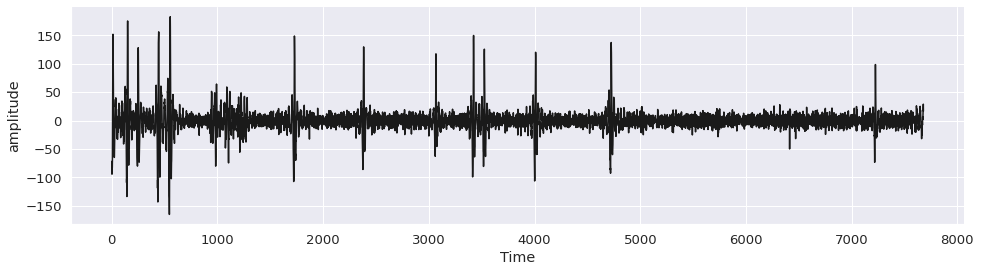

In [ ]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(1,7680) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(data[0,3,:], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('amplitude')
sns.despine()

rawdata=np.array(rawdata)
print(rawdata.shape)
rawdata1=rawdata.flatten()
raw2=rawdata1.reshape(880*32,7680)
print(raw2.shape)

In [ ]:
####  we need  to normailize and standardize data to reduce computaional cost of deep learning 

sscaler = StandardScaler()
# fit scaler on data
sscaler.fit(raw2)
# apply transform
standardized = sscaler.transform(raw2)  # (data -mean)/standard deviation

scaler = MinMaxScaler()
# fit scaler on data
scaler.fit(standardized)  # values between 0,1
# apply transform
nx_train = scaler.transform(standardized)

# #### stack the data of all 22 subject to create  3D numpy array
#  22*40=880  trials
#  each trail has 32 chanales  and 7680 sampleas

print(nx_train.shape)
rawdata=nx_train.flatten()
rawdata=rawdata.reshape(880,32,7680)


# # lets create training val and test set of EE data

# Re-shape arrays into desired shapes

rawdata =np.array(rawdata)
rawdata = rawdata.flatten()

# create  60 1 second epochs  for time distributed network
eeg_data_epoched=rawdata.reshape(880,60,32*128,1)
eeg_data = rawdata.reshape(880, 32, 7680)

x_train_eeg=eeg_data_epoched[0:640 ,:,:,:]  # train set  16 subjects [16*40=640]
x_val_eeg=eeg_data_epoched[640:760 ,:,:,:] # val set 3 subjects 3* 40=120
x_test_eeg=eeg_data_epoched[760:880 ,:,:,:] # test set 3 subjects  3* 40=120
print(x_train_eeg.shape)
print(x_val_eeg.shape)
print(x_test_eeg.shape)

np.save("/content/drive/MyDrive/dataset/x_train_eeg.npy",x_train_eeg)
np.save("/content/drive/MyDrive/dataset/x_val_eeg.npy",x_val_eeg)
np.save("/content/drive/MyDrive/dataset/x_test_eeg.npy",x_test_eeg)

labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(880, 4)


(28160, 7680)
(640, 60, 4096, 1)
(120, 60, 4096, 1)
(120, 60, 4096, 1)


In [ ]:
labels

array([[7.71, 7.6 , 6.9 , 7.83],
       [8.1 , 7.31, 7.28, 8.47],
       [8.58, 7.54, 9.  , 7.08],
       ...,
       [1.  , 7.05, 1.97, 1.  ],
       [1.  , 7.01, 4.03, 1.  ],
       [2.97, 1.96, 5.04, 1.03]])

In [ ]:
def assignNewLabels(classify):
     if classify['Valence'] >= 4.00 and classify['Arousal'] >= 4.00 :
         return 1
     else:
       return 0

# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())

labels_valance = []
labels_valance = df_label_ratings.apply(lambda classify: assignNewLabels(classify), axis=1)
#Label mapping
event_id = dict(pv = 1, nv = 0)

# print(df_label_ratings.head(15))
labels_valance.value_counts()


df_label_ratings_v = pd.DataFrame({'Valence': labels[:,0]})
print(df_label_ratings_v.head(5))


print('labels', df_label_ratings_v.shape )


def assignNewLabels(df_label_ratings_v):
    if df_label_ratings_v >= 4.00:
        return 1
    else:
      return 0


df_labels_v =[]
df_labels_v = df_label_ratings_v['Valence'].apply(assignNewLabels)
#Label mapping
event_id = dict(pv = 1, nv = 0)
print(df_labels_v.head(5))
print(event_id)
y = np.ravel(df_labels_v)
#Labels
y = pd.DataFrame(y) 
# Splitting data into Train data ; 16 participants eeg data(i.e. 640 vid trials)
y_train = y[0:640]
y_train = y_train.to_numpy()
y_val = y[640:760]
y_val = y_val.to_numpy()
print('Training labels',y_train.shape)
y_test = y[760:880]
y_test = y_test.to_numpy()
print('Testing labels', y_test.shape)


y=y.to_numpy()
np.save("/content/drive/MyDrive/dataset/y_train.npy",y_train)
np.save("/content/drive/MyDrive/dataset/y_test.npy",y_test)
np.save("/content/drive/MyDrive/dataset/y_val.npy",y_val)


# read  EEG traing  validation and test sets  from  drive
eegx_train =np.load("/content/drive/MyDrive/dataset/x_train_eeg.npy",allow_pickle=True)
eegx_test =np.load("/content/drive/MyDrive/dataset/x_test_eeg.npy",allow_pickle=True)
eegx_val =np.load("/content/drive/MyDrive/dataset/x_val_eeg.npy",allow_pickle=True)
y_test=np.load("/content/drive/MyDrive/dataset/y_test.npy",allow_pickle=True)
y_train=np.load("/content/drive/MyDrive/dataset/y_train.npy",allow_pickle=True)
y_val=np.load("/content/drive/MyDrive/dataset/y_val.npy",allow_pickle=True)

# print sizes of the sets 
print(eegx_train.shape ,y_train.shape,eegx_val.shape,y_val.shape,eegx_test.shape,y_test.shape)
y_train1 =y_train
print(y_train1.shape)
eegx_train=eegx_train[:,:30,:,:]/10000
eegx_val=eegx_val[:,:30,:,:]
eegx_val.shape
eegx_test=eegx_test[:,:30,:,:]

# ####one hot encoding of labels 

y_train=to_categorical(y_train,2)
y_val=to_categorical(y_val,2)
y_test=to_categorical(y_test,2)
print(y_val.shape)


# del raw2 ,rawdata,rawdata1,eeg_data,eeg_data_epoched,data


# del facex_test,facex_train, x_test_eeg,x_train_eeg



          Valence     Arousal
count  880.000000  880.000000
mean     5.218034    5.238898
std      2.093837    1.879631
min      1.000000    1.000000
25%      3.650000    3.895000
50%      5.040000    5.490000
75%      7.040000    6.795000
max      9.000000    9.000000
   Valence
0     7.71
1     8.10
2     8.58
3     4.94
4     6.96
labels (880, 1)
0    1
1    1
2    1
3    1
4    1
Name: Valence, dtype: int64
{'pv': 1, 'nv': 0}
Training labels (640, 1)
Testing labels (120, 1)
(640, 60, 4096, 1) (640, 1) (120, 60, 4096, 1) (120, 1) (120, 60, 4096, 1) (120, 1)
(640, 1)
(120, 2)


In [ ]:

def custom_loss(y_true, y_pred, delta=0.6): 
    y_pred = tf.cast(y_pred, dtype=backend.floatx()) #y_pred: tensor of predicted targets 
    
    y_true = tf.cast(y_true, dtype=backend.floatx()) #y_true: tensor of true targets.
    delta = tf.cast(delta, dtype=backend.floatx()) #delta the point where the loss function changes from aquadratic to linear
    
    y_pred = tf.convert_to_tensor(y_pred) 
    y_true = tf.cast(y_true, y_pred.dtype) 
    def Sub_deco_log(x):
        return x + tf.math.exp(-2.*x)
    error=backend.mean(Sub_deco_log(y_pred - y_true), axis=-1)


    abs_error = tf.abs(error)
    half = tf.convert_to_tensor(0.5, dtype=abs_error.dtype)
    #Tensor with one scalar loss entry per sample
    return backend.mean(tf.where(abs_error <= delta, half *tf.square(error),delta *abs_error - half * tf.square(delta)),
          axis=-1)

In [ ]:
import cv2
import numpy as np
x_train_face = cv2.normalize(x_train_face, None, alpha=0,beta=200, norm_type=cv2.NORM_MINMAX)

In [ ]:
x_train_face1 = x_train_face/255

In [ ]:
x_train_face.shape

(640, 30, 175, 175, 1)

In [ ]:
x_train_face.shape

(640, 30, 175, 175, 1)

In [ ]:
eegx_train.shape

(640, 30, 4096, 1)

In [ ]:
eegx_train1 =eegx_train.reshape(640*30,4096)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(eegx_train1)
# transform training dataset
eegx_train2 = scaler.transform(eegx_train1)
# transform test dataset

In [ ]:
eegx_train3 =eegx_train2.reshape(640, 30, 4096, 1)

In [ ]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [ ]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Convolution3D,Activation,Input

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 175, 17  0           []                               
                                5, 1)]                                                            
                                                                                                  
 input_2 (InputLayer)           [(None, 30, 4096, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv3d (Conv3D)                (None, 28, 173, 173  168         ['input_1[0][0]']                
                                , 6)                                                          

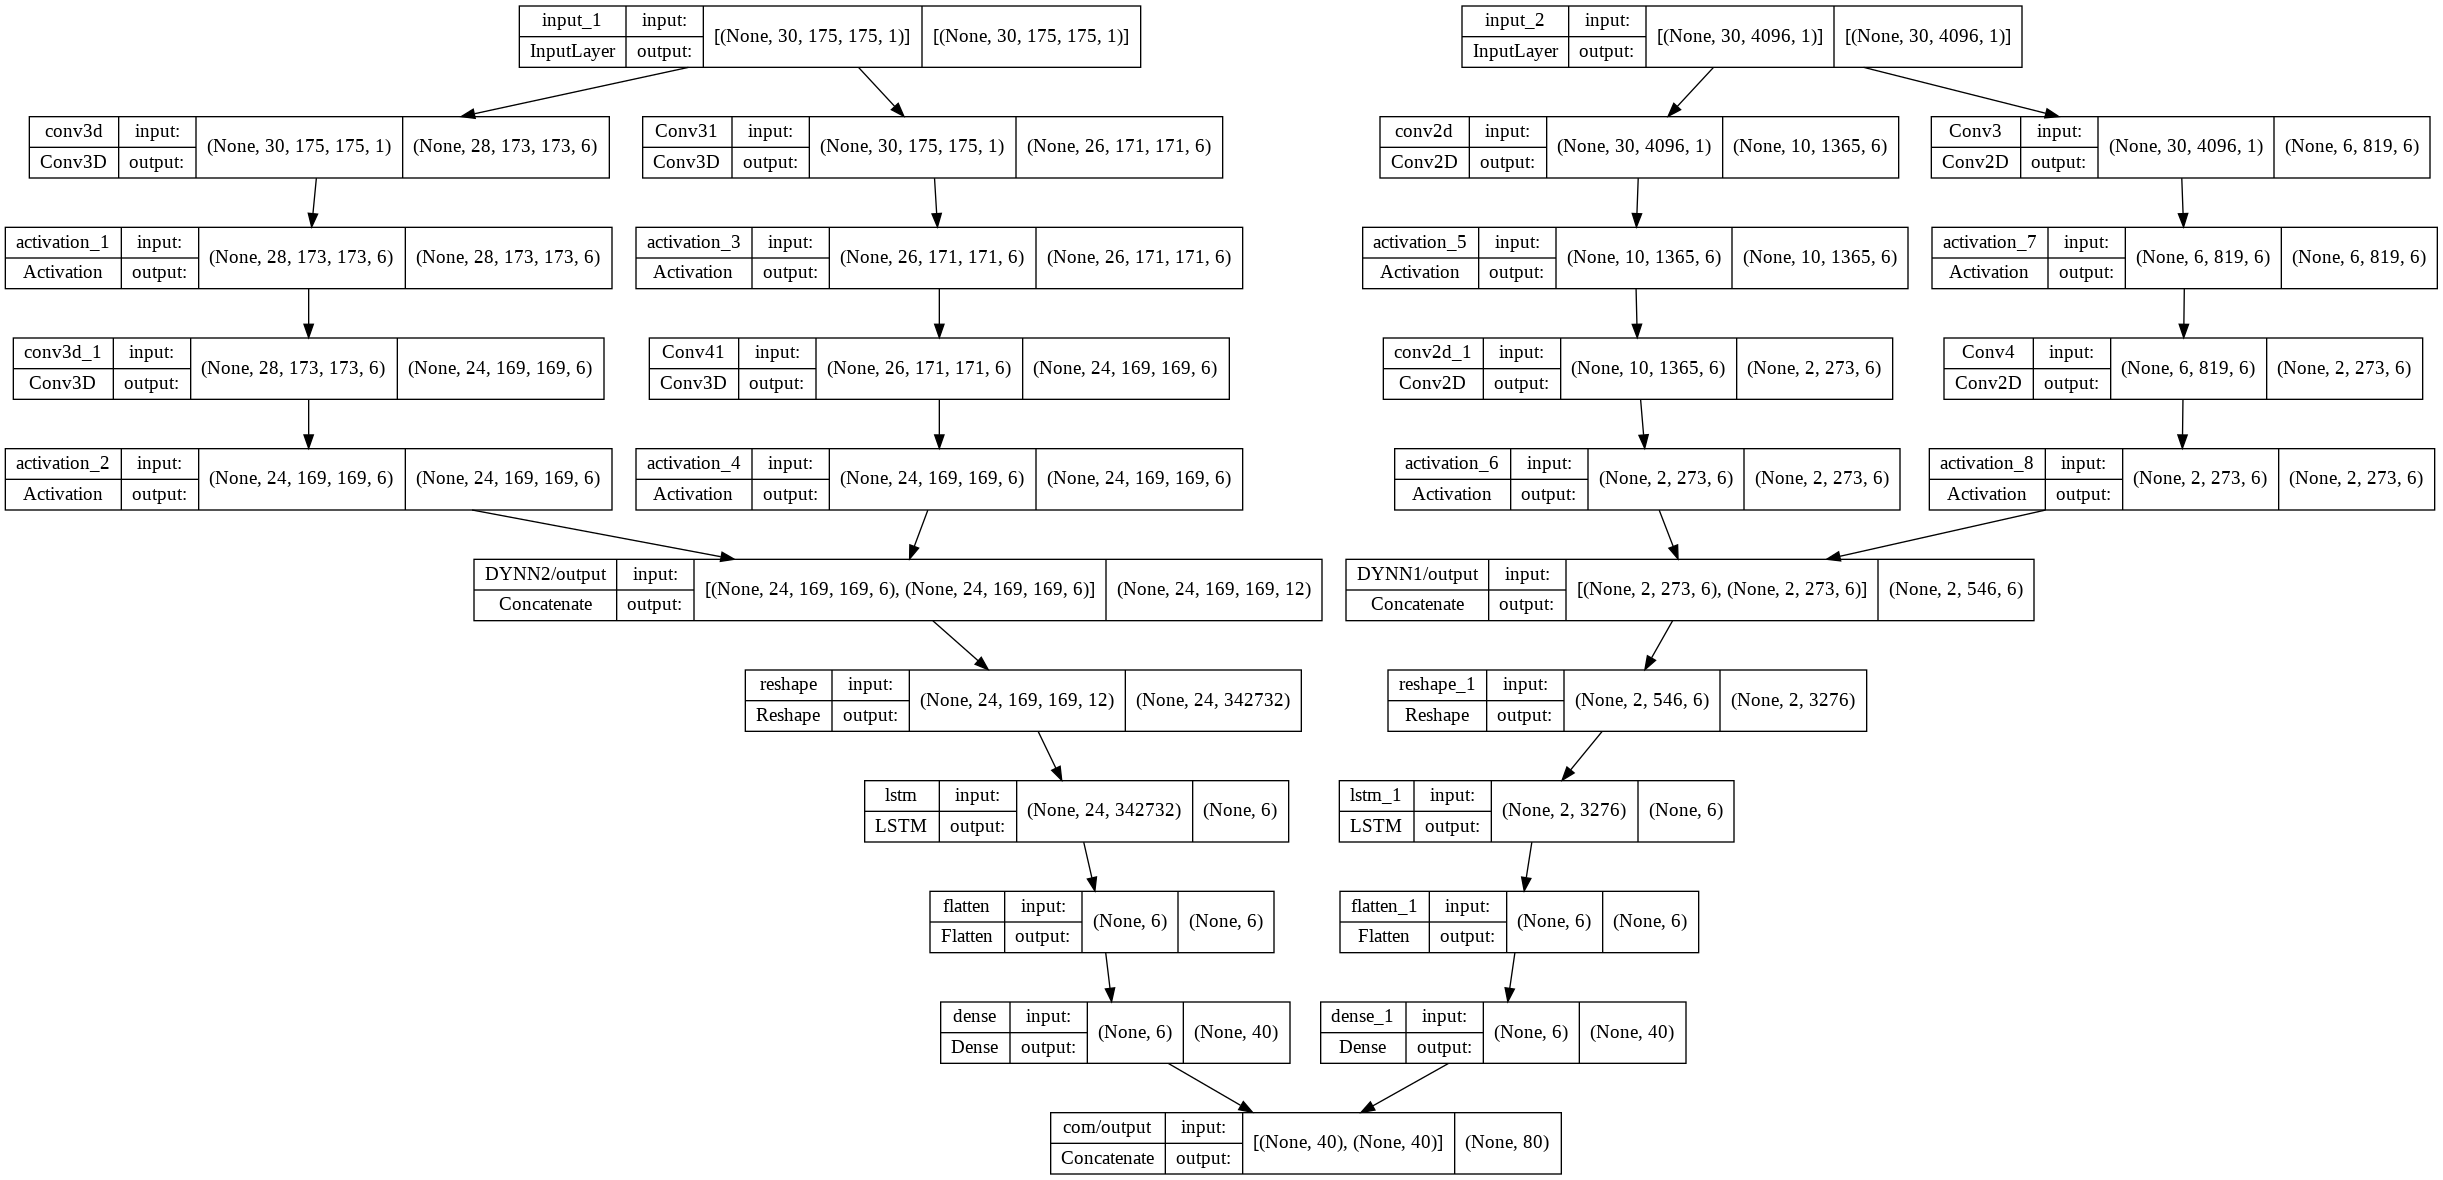

In [ ]:
import keras
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
input_shape1 =input_shape=(30, 175, 175, 1)
num_classes = 2
rnn_size=64
#
input1 = keras.Input(shape=input_shape1)
x=keras.layers.Convolution3D(6, 3,input_shape=input_shape1)(input1)
x=keras.layers.Activation('relu')(x)
x=keras.layers.Convolution3D(6, 5,input_shape=input_shape1)(x)
x=keras.layers.Activation('relu')(x)
x1=keras.layers.Convolution3D(6, 5,input_shape=input_shape1,name='Conv31')(input1)
x1=keras.layers.Activation('relu')(x1)
x1=keras.layers.Convolution3D(6, 3,input_shape=input_shape1,name='Conv41')(x1)
x1=keras.layers.Activation('relu')(x1)
x_1 = keras.layers.Concatenate(axis=4, name='DYNN2/output')([x, x1])

conv_shape = x_1.get_shape()
x_1 = keras.layers.Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3]*conv_shape[4])))(x_1)

x_1=keras.layers.LSTM(6, activation='relu', return_sequences=False)(x_1)

x_1=keras.layers.Flatten()(x_1)
x_1=keras.layers.Dense(40)(x_1)

############################################################################################################
import keras
input_shape2 =(30,4096,1)
num_classes = 2
rnn_size=64
#
input2 = keras.Input(shape=input_shape2)
x=keras.layers.Convolution2D(6, 3, 3,input_shape=input_shape2)(input2)
x=keras.layers.Activation('relu')(x)
x=keras.layers.Convolution2D(6, 5, 5,input_shape=input_shape2)(x)
x=keras.layers.Activation('relu')(x)

x1=keras.layers.Convolution2D(6, 5, 5,input_shape=input_shape2,name='Conv3')(input2)
x1=keras.layers.Activation('relu')(x1)

x1=keras.layers.Convolution2D(6, 3, 3,input_shape=input_shape2,name='Conv4')(x1)
x1=keras.layers.Activation('relu')(x1)

x_ = keras.layers.Concatenate(axis=2, name='DYNN1/output')([x, x1])

# x=keras.layers.Flatten()(x)
conv_shape = x_.get_shape()
x_ = keras.layers.Reshape(target_shape=(int(conv_shape[1]),int(conv_shape[2]*conv_shape[3])))(x_)

x_2=keras.layers.LSTM(6, activation='relu', return_sequences=False)(x_)

x_2=keras.layers.Flatten()(x_2)

x_2=keras.layers.Dense(40)(x_2)
def custom_layer(tensor):
    tensor1 = tensor[0]
    tensor2 = tensor[1]
    return tensor1 * tensor2

#x = Lambda(custom_layer)([x_1,x_2]) 
x0 = keras.layers.Concatenate(axis=1, name='com/output')([x_1, x_2])
x = Dropout(0.25)(x)
x = Dense(16, activation = 'swish')(x)
#modeltmp = BatchNormalization()(modeltmp)
x= Dense(8, activation = 'swish')(x)
x=keras.layers.Dropout(0.25)(x)
#
x=keras.layers.Dense(2, activation='softmax')(x)
model_main=keras.Model(inputs=[input1,input2],outputs=x0)

model_main.summary()
# epochs = 30
adam = tf.keras.optimizers.Adam(learning_rate = 0.03)
model_main.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
plot_model(model_main, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
out = model_main.predict([x_train_face1,eegx_train3])

In [ ]:
facex_test =np.load("/content/drive/MyDrive/dataset/x_test_face.npy",allow_pickle=True)
facex_test=facex_test[120:,:30,:,:,:]/10000
test_out = model_main.predict([facex_test,eegx_test])

In [ ]:
out.shape

(640, 80)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='not minority',random_state=10)
X_sm, y_sm = smote.fit_resample(out, y_train1.ravel())
print(X_sm.shape, y_sm.shape)

(640, 80) (640,)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

OS = RandomUnderSampler(sampling_strategy='auto', random_state=0)
X_rus, y_rus = OS.fit_resample(out, y_train1.ravel())
print(X_rus.shape, y_rus.shape)

(396, 80) (396,)


In [ ]:
from imblearn.over_sampling import RandomOverSampler

OS = RandomOverSampler(sampling_strategy='auto', random_state=0)
X_ros, y_ros = OS.fit_resample(out, y_train1.ravel())
print(X_ros.shape, y_ros.shape)

(884, 80) (884,)


In [ ]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_KNN, y_KNN = cc.fit_resample(out, y_train1.ravel())
print(X_KNN.shape, y_KNN.shape)

(396, 80) (396,)


In [ ]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule()
X_resampled, y_resampled = ncr.fit_resample(out, y_train1.ravel())
print(X_resampled.shape, y_resampled.shape)

(459, 80) (459,)


In [ ]:
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=[0, 1], random_state=0)
X_SMOTENC, y_SMOTENC = smote_nc.fit_resample(out, y_train1.ravel())
print(X_SMOTENC.shape, y_SMOTENC.shape)

(884, 80) (884,)


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
X_ADASYN, y_ADASYN = ADASYN().fit_resample(out, y_train1.ravel())
print(X_ADASYN.shape, y_ADASYN.shape)

(867, 80) (867,)


In [ ]:
X_sm1, y_sm1 =pd.DataFrame(X_sm), pd.DataFrame (y_sm) 
X_ros1, y_ros1  =pd.DataFrame(X_ros), pd.DataFrame (y_ros) 
X_rus1, y_rus1  =pd.DataFrame(X_rus), pd.DataFrame (y_rus) 
X_ADASYN1, y_ADASYN1  =pd.DataFrame(X_ADASYN), pd.DataFrame (y_ADASYN) 
X_SMOTENC1, y_SMOTENC1  =pd.DataFrame(X_SMOTENC), pd.DataFrame (y_SMOTENC) 
X_KNN1, y_KNN1  =pd.DataFrame(X_KNN), pd.DataFrame (y_KNN) 

In [ ]:
y_test1=[]
for x in y_test:
  y_test1.append(np.argmax(x))


In [ ]:
y_test1 = np.array(y_test1)
print(y_test1.shape)

(120,)


In [ ]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_KNNt, y_KNNt = cc.fit_resample(test_out, y_test1.ravel())
print(X_KNNt.shape, y_KNNt.shape)

(64, 80) (64,)


In [ ]:
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=[0, 1], random_state=0)
X_SMOTENCt, y_SMOTENCt = smote_nc.fit_resample(test_out, y_test1.ravel())
print(X_SMOTENCt.shape, y_SMOTENCt.shape)

(176, 80) (176,)


In [ ]:
df5 = pd.concat([X_SMOTENC1,X_KNN1,pd.DataFrame(out),pd.DataFrame(test_out)])
print(df5.shape)
target5 = pd.concat([y_SMOTENC1,y_KNN1,pd.DataFrame(y_train1),pd.DataFrame(y_test1)])
print(target5.shape)

(2040, 80)
(2040, 1)


In [ ]:
target5.value_counts()

1    1170
0     870
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_trainsm, X_testsm, y_trainsm, y_testsm = train_test_split(np.array(df5),np.array(target5).ravel(), test_size=0.2, random_state=6)
print(X_trainsm.shape, X_testsm.shape, y_trainsm.shape, y_testsm.shape)

(1632, 80) (408, 80) (1632,) (408,)


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
import time
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import time
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import pandas as pd
import numpy as np
from scipy import interp

from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
  if y_true.shape != y_pred.shape:
    print("Error! y_true %s is not the same shape as y_pred %s" % (
          y_true.shape,
          y_pred.shape)
        )
    return

  lb = LabelBinarizer()

  if len(y_true.shape) == 1:
        lb.fit(y_true)

  #Value counts of predictions
  labels, cnt = np.unique(y_pred,return_counts=True)
  n_classes = len(labels)
  pred_cnt = pd.Series(cnt, index=labels)

  metrics_summary = precision_recall_fscore_support(y_true=y_true,y_pred=y_pred,labels=labels)

  avg = list(precision_recall_fscore_support(y_true=y_true, y_pred=y_pred,average='weighted'))

  metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
  class_report_df = pd.DataFrame(list(metrics_summary),index=metrics_sum_index,columns=labels)

  support = class_report_df.loc['support']
  total = support.sum() 
  class_report_df['avg / total'] = avg[:-1] + [total]

  class_report_df = class_report_df.T
  class_report_df['pred'] = pred_cnt
  class_report_df['pred'].iloc[-1] = total

  if not (y_score is None):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for label_it, label in enumerate(labels):
      fpr[label], tpr[label], _ = roc_curve((y_true == label).astype(int), y_score[:, label_it])
      roc_auc[label] = auc(fpr[label], tpr[label])

    if average == 'micro':
      if n_classes <= 2:
        fpr["avg / total"], tpr["avg / total"], _ = roc_curve(lb.transform(y_true).ravel(), y_score[:, 1].ravel())
      else:
        fpr["avg / total"], tpr["avg / total"], _ = roc_curve(lb.transform(y_true).ravel(), y_score.ravel())

      roc_auc["avg / total"] = auc(fpr["avg / total"],tpr["avg / total"])

    elif average == 'macro':
      # First aggregate all false positive rates
      all_fpr = np.unique(np.concatenate([fpr[i] for i in labels]))
      # Then interpolate all ROC curves at this points
      mean_tpr = np.zeros_like(all_fpr)
      for i in labels:
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
      mean_tpr /= n_classes
      fpr["macro"] = all_fpr
      tpr["macro"] = mean_tpr
      roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

    class_report_df['AUC'] = pd.Series(roc_auc)

  return class_report_df

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
model=XGBClassifier(n_estimators=120,max_depth=100,learning_rate=0.8)

In [ ]:
model.fit(X_trainsm, y_trainsm)
y_pred_trainsm = model.predict(X_trainsm)
y_predsm = model.predict(X_testsm)
accuracy_trainsm = accuracy_score(y_trainsm, y_pred_trainsm)
accuracysm = accuracy_score(y_testsm, y_predsm)
print("Accuracysm: %.2f%%" % (accuracysm * 100.0))
print("Accuracy trainsm: %.2f%%" % (accuracy_trainsm * 100.0))

Accuracysm: 93.63%
Accuracy trainsm: 100.00%


In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 41, num = 5)]
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
learning_rate=[0.001,0.01,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,0.99]
boost=['gbtree', 'gblinear']
num_featurer=[90,100,120,140,200]
max_depth
# Minimum number of samples required to split a node
# Method of selecting samples for training each tree
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'booster':boost,
               'features':num_featurer}
# Create a based model
print(max_depth)
model0 = XGBClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model0, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 3)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]


In [ ]:
#grid_search.fit(X_trainsm, y_trainsm)

In [ ]:
#grid_search.best_params_

In [ ]:
#grid_search.best_score_

In [ ]:
!pip install scikit-plot

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [ ]:
probas = model.predict_proba(X_testsm)

In [ ]:
y_testsm = y_testsm.reshape(y_testsm.shape[0])
y_predsm = y_predsm.reshape(y_testsm.shape[0])
print(y_testsm.shape,y_predsm.shape)


(408,) (408,)


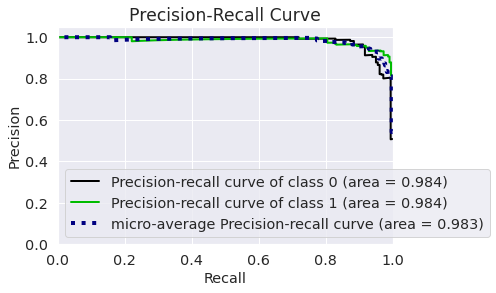

In [ ]:
skplt.metrics.plot_precision_recall(y_testsm,probas)

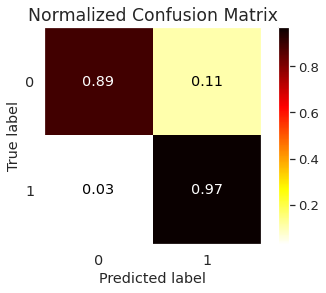

In [ ]:
skplt.metrics.plot_confusion_matrix(y_testsm,y_predsm, normalize=True, cmap='hot_r')
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


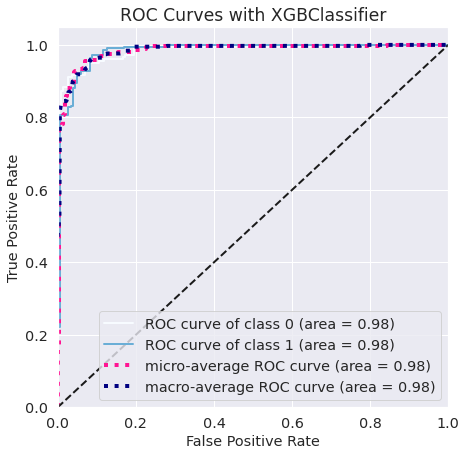

In [ ]:
skplt.metrics.plot_roc_curve(y_testsm,probas,title="ROC Curves with XGBClassifier", cmap='Blues', figsize=[7,7])
plt.show()

In [ ]:
report_with_auc = class_report(
    y_true=y_testsm, 
    y_pred=model.predict(X_testsm), 
    y_score=model.predict_proba(X_testsm))
print("XGBClassifier\n",report_with_auc)

XGBClassifier
              precision    recall  f1-score  support   pred       AUC
0             0.964286  0.890110  0.925714    182.0  168.0  0.983954
1             0.916667  0.973451  0.944206    226.0  240.0  0.983954
avg / total   0.937908  0.936275  0.935957    408.0  408.0  0.983954


In [ ]:
log_clf = LogisticRegression(penalty='l2',max_iter=1000,C=1,solver='lbfgs',l1_ratio=None)
log_clf.fit(X_trainsm, y_trainsm)
y_pred_trainsmlog_clf = log_clf.predict(X_trainsm)
y_predsmlog_clf = log_clf.predict(X_testsm)
accuracy_trainsm = accuracy_score(y_trainsm, y_pred_trainsmlog_clf)
accuracysm = accuracy_score(y_testsm, y_predsmlog_clf)
print("Accuracysm of log_clf: %.2f%%" % (accuracysm * 100.0))
print("Accuracy trainsm of log_clf: %.2f%%" % (accuracy_trainsm * 100.0))

Accuracysm of log_clf: 55.15%
Accuracy trainsm of log_clf: 57.72%


In [ ]:
probas1 = log_clf.predict_proba(X_testsm)

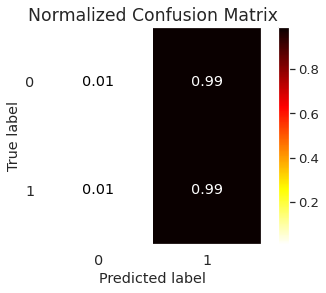

In [ ]:
skplt.metrics.plot_confusion_matrix(y_testsm,log_clf.predict(X_testsm), normalize=True, cmap='hot_r')
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


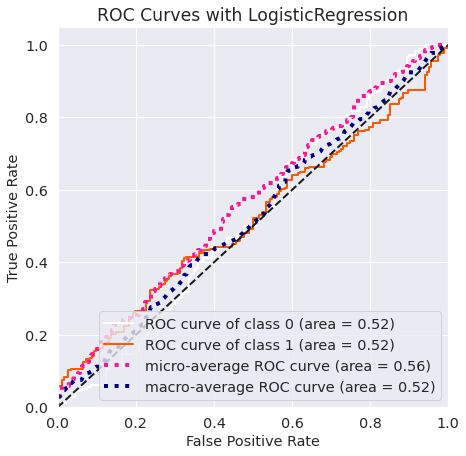

In [ ]:
skplt.metrics.plot_roc_curve(y_testsm,probas1,title="ROC Curves with LogisticRegression", cmap='hot_r', figsize=[7,7])
plt.show()

In [ ]:
report_with_auc = class_report(
    y_true=y_testsm, 
    y_pred=log_clf.predict(X_testsm), 
    y_score=log_clf.predict_proba(X_testsm))
print("logistic regression\n",report_with_auc)

logistic regression
              precision    recall  f1-score  support   pred       AUC
0             0.333333  0.005495  0.010811    182.0    3.0  0.521249
1             0.553086  0.991150  0.709984    226.0  405.0  0.521249
avg / total   0.455059  0.551471  0.398098    408.0  408.0  0.521249


In [ ]:
RandomForest=RandomForestClassifier(max_depth=80,max_features=3,min_samples_leaf=3,min_samples_split=12,n_estimators=40)
RandomForest.fit(X_trainsm, y_trainsm)
y_pred_trainsm_rnd = RandomForest.predict(X_trainsm)
y_predsm_rnd = RandomForest.predict(X_testsm)
accuracy_trainsm = accuracy_score(y_trainsm, y_pred_trainsm_rnd)
accuracysm = accuracy_score(y_testsm, y_predsm_rnd)
print("Accuracysm of random_forest: %.2f%%" % (accuracysm * 100.0))
print("Accuracy trainsm of random_forest: %.2f%%" % (accuracy_trainsm * 100.0))

Accuracysm of random_forest: 93.38%
Accuracy trainsm of random_forest: 98.84%


In [ ]:
RandomForest=RandomForestClassifier(bootstrap= False,max_depth= 110,max_features= 1,min_samples_leaf= 1,min_samples_split= 5,n_estimators= 50)

In [ ]:
RandomForest.fit(X_trainsm, y_trainsm)
y_pred_trainsm_rnd = RandomForest.predict(X_trainsm)
y_predsm_rnd = RandomForest.predict(X_testsm)
accuracy_trainsm = accuracy_score(y_trainsm, y_pred_trainsm_rnd)
accuracysm = accuracy_score(y_testsm, y_predsm_rnd)
print("Accuracysm of random_forest: %.2f%%" % (accuracysm * 100.0))
print("Accuracy trainsm of random_forest: %.2f%%" % (accuracy_trainsm * 100.0))

Accuracysm of random_forest: 94.36%
Accuracy trainsm of random_forest: 100.00%


In [ ]:
probas2 = RandomForest.predict_proba(X_testsm)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


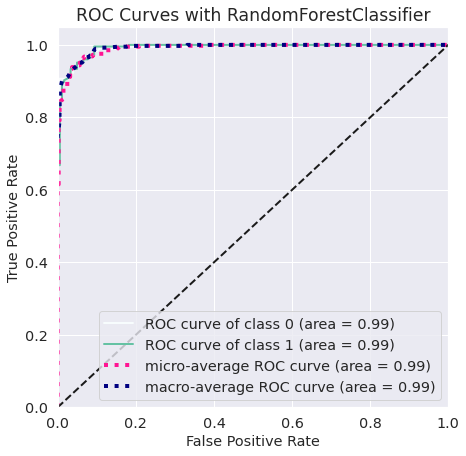

In [ ]:
skplt.metrics.plot_roc_curve(y_testsm,probas2,title="ROC Curves with RandomForestClassifier", cmap='BuGn', figsize=[7,7])
plt.show()

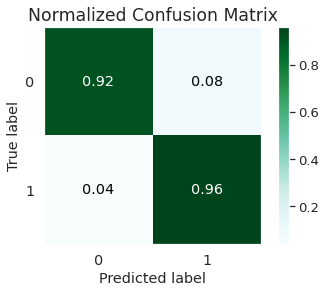

In [ ]:
skplt.metrics.plot_confusion_matrix(y_testsm,y_predsm_rnd, normalize=True,cmap='BuGn')
plt.show()

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_model=SVC(C=3.4000000000000004, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
svm_model.fit(X_trainsm, y_trainsm)
y_pred_trainsm_rnd =svm_model.predict(X_trainsm)
y_predsm_rnd = svm_model.predict(X_testsm)
accuracy_trainsm = accuracy_score(y_trainsm, y_pred_trainsm_rnd)
accuracysm = accuracy_score(y_testsm, y_predsm_rnd)
print("Accuracysm of random_forest: %.2f%%" % (accuracysm * 100.0))
print("Accuracy trainsm of random_forest: %.2f%%" % (accuracy_trainsm * 100.0))

Accuracysm of random_forest: 55.39%
Accuracy trainsm of random_forest: 58.03%


In [ ]:
svm_model=SVC(C=3.4000000000000004, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
svm_model.fit(X_trainsm, y_trainsm)
report_with_auc = class_report(
    y_true=y_testsm, 
    y_pred=svm_model.predict(X_testsm), 
    y_score=svm_model.predict_proba(X_testsm))
print(" SVM classifier\n",report_with_auc)

 SVM classifier
              precision    recall  f1-score  support   pred       AUC
1             0.553922  1.000000  0.712934    226.0  408.0  0.422129
avg / total   0.306829  0.553922  0.394909    226.0  226.0  0.577871


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
svm = SVC()
param_grid = {'C': [i for i in np.linspace(0.1,10,10)], 
              'kernel': ['rbf', 'sigmoid'],
              'degree' : [2,4,6,8,10,12]} 
  
grid = GridSearchCV(svm, param_grid,cv=5 ,refit = True, verbose = 3)
grid.fit(X_trainsm, y_trainsm)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END .......C=0.1, degree=2, kernel=rbf;, score=0.578 total time=   0.2s
[CV 2/5] END .......C=0.1, degree=2, kernel=rbf;, score=0.578 total time=   0.2s
[CV 3/5] END .......C=0.1, degree=2, kernel=rbf;, score=0.577 total time=   0.2s
[CV 4/5] END .......C=0.1, degree=2, kernel=rbf;, score=0.580 total time=   0.2s
[CV 5/5] END .......C=0.1, degree=2, kernel=rbf;, score=0.580 total time=   0.2s
[CV 1/5] END ...C=0.1, degree=2, kernel=sigmoid;, score=0.578 total time=   0.2s
[CV 2/5] END ...C=0.1, degree=2, kernel=sigmoid;, score=0.578 total time=   0.2s
[CV 3/5] END ...C=0.1, degree=2, kernel=sigmoid;, score=0.577 total time=   0.2s
[CV 4/5] END ...C=0.1, degree=2, kernel=sigmoid;, score=0.580 total time=   0.2s
[CV 5/5] END ...C=0.1, degree=2, kernel=sigmoid;, score=0.580 total time=   0.2s
[CV 1/5] END .......C=0.1, degree=4, kernel=rbf;, score=0.578 total time=   0.2s
[CV 2/5] END .......C=0.1, degree=4, kernel=rb

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1.2000000000000002, 2.3000000000000003,
                               3.4000000000000004, 4.5, 5.6, 6.7,
                               7.800000000000001, 8.9, 10.0],
                         'degree': [2, 4, 6, 8, 10, 12],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=3)

In [ ]:
grid.best_params_

{'C': 5.6, 'degree': 2, 'kernel': 'rbf'}

In [ ]:
grid.best_score_

0.5833361475394458

In [ ]:
svm_model=SVC(C=7, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
svm_model.fit(X_trainsm, y_trainsm)
report_with_auc = class_report(
    y_true=y_testsm, 
    y_pred=svm_model.predict(X_testsm), 
    y_score=svm_model.predict_proba(X_testsm))
print(" SVM classifier\n",report_with_auc)

 SVM classifier
              precision    recall  f1-score  support   pred       AUC
1             0.553922  1.000000  0.712934    226.0  408.0  0.424706
avg / total   0.306829  0.553922  0.394909    226.0  226.0  0.575294


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
probas2 = svm_model.predict_proba(X_testsm)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


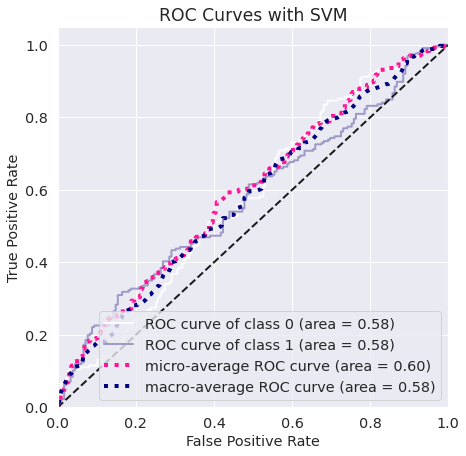

In [ ]:
skplt.metrics.plot_roc_curve(y_testsm,probas2,title="ROC Curves with SVM", cmap='Purples', figsize=[7,7])
plt.show()

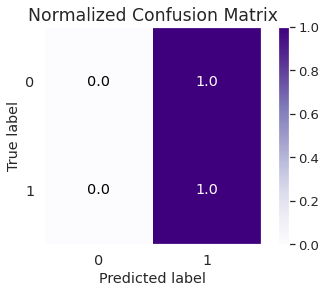

In [ ]:
skplt.metrics.plot_confusion_matrix(y_testsm,y_predsm_rnd, normalize=True,cmap='Purples')
plt.show()

In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
clf1 = XGBClassifier(n_estimators=80,max_depth=100,learning_rate=0.8)
clf3 = RandomForestClassifier(max_depth=80,max_features=3,min_samples_leaf=3,min_samples_split=12,n_estimators=40)
clf4 = VotingClassifier(
estimators=[('XGB', clf1), ('RandomForestClassifier',clf3)],voting='soft')


print('3-fold cross validation:\n')

labels = ['XGB', 'RandomForestClassifier','VotingClassifier' ]

for clf, label in zip([clf1, clf3, clf4], labels):

    scores = model_selection.cross_val_score(clf,np.array(df5),np.array(target5).ravel(), 
                                              cv=3, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.96 (+/- 0.01) [XGB]
Accuracy: 0.95 (+/- 0.01) [RandomForestClassifier]
Accuracy: 0.96 (+/- 0.01) [VotingClassifier]


In [ ]:
clf4.fit(X_trainsm, y_trainsm)

VotingClassifier(estimators=[('XGB',
                              XGBClassifier(learning_rate=0.8, max_depth=100,
                                            n_estimators=80)),
                             ('RandomForestClassifier',
                              RandomForestClassifier(max_depth=80,
                                                     max_features=3,
                                                     min_samples_leaf=3,
                                                     min_samples_split=12,
                                                     n_estimators=40))],
                 voting='soft')

In [ ]:
probas = clf4.predict_proba(X_testsm)

In [ ]:
y_testsm = y_testsm.reshape(y_testsm.shape[0])
y_predsm = y_predsm.reshape(y_testsm.shape[0])
print(y_testsm.shape,y_predsm.shape)


(408,) (408,)


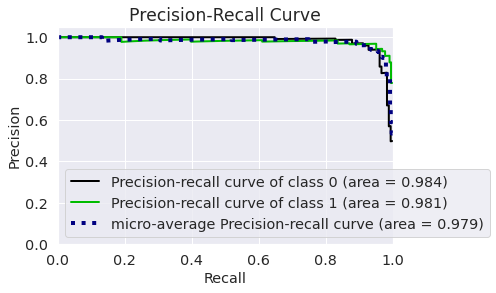

In [ ]:
skplt.metrics.plot_precision_recall(y_testsm,probas)

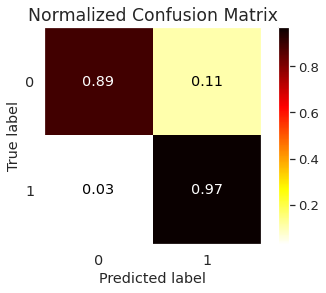

In [ ]:
skplt.metrics.plot_confusion_matrix(y_testsm,y_predsm, normalize=True, cmap='hot_r')
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


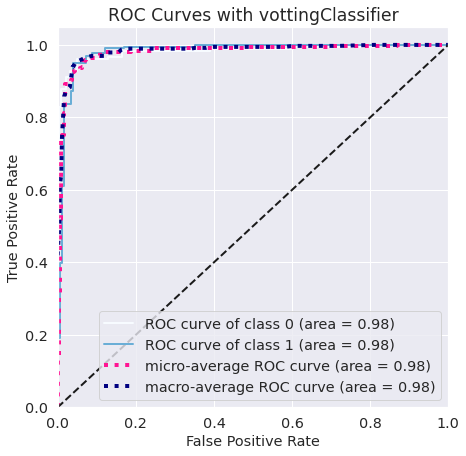

In [ ]:
skplt.metrics.plot_roc_curve(y_testsm,probas,title="ROC Curves with vottingClassifier", cmap='Blues', figsize=[7,7])
plt.show()

In [ ]:
#all_variables = dir()
  ### 0,1 or 1,0
#for name in all_variables:
    
#    if not name.startswith('__'):
#        myvalue = eval(name)
#        print(name, "is", type(myvalue))


#import collections
#collections.Counter(np.argmax(y_train,axis=1))


#from keras.layers import *
#from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
#learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
#                                            patience=10,
#                                            verbose=1,
#                                            factor=0.5,
#                                            min_lr=0.01)


#earlyStopping = EarlyStopping(monitor='loss', patience=60, verbose=0, mode='min')

#history=model.fit([x_train_face1,eegx_train3], y_train, batch_size=8,validation_batch_size =8, epochs=1000, validation_split=0.3,
#                  callbacks=[earlyStopping,learning_rate_reduction],
#              verbose=True)



In [ ]:

facex_test =np.load("/content/drive/MyDrive/dataset/x_test_face.npy",allow_pickle=True)
facex_test=facex_test[120:,:30,:,:,:]/10000
test_out = model_main.predict([facex_test,eegx_test])
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])
print(test_out.shape)

(120, 80)


In [ ]:
pd.DataFrame(y_test1).value_counts()

1    88
0    32
dtype: int64

In [ ]:
probas = clf4.predict_proba(np.array(test_out))
y_predsm = clf4.predict(np.array(test_out))
probas.shape

(120, 2)

In [ ]:
y_testsm = np.array(y_test1).reshape(np.array(y_test1).shape[0])
y_predsm = y_predsm.reshape(y_testsm.shape[0])
print(y_testsm.shape,y_predsm.shape)


(120,) (120,)


In [ ]:
print("Accuracy test set of voting classifier: %.2f%%" % (accuracy_score(y_testsm, y_predsm)* 100.0))

Accuracy test set of voting classifier: 98.33%


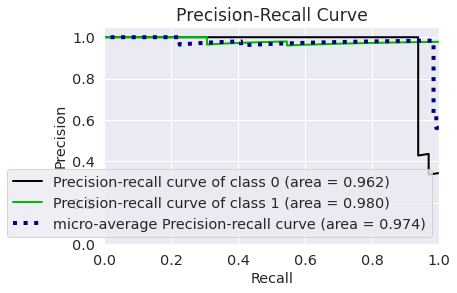

In [ ]:
skplt.metrics.plot_precision_recall(y_testsm,probas)

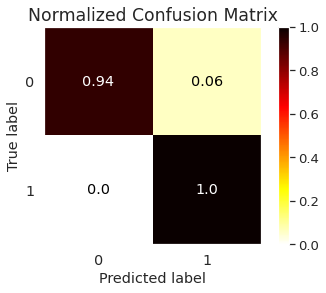

In [ ]:
skplt.metrics.plot_confusion_matrix(y_testsm,y_predsm, normalize=True, cmap='hot_r')
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


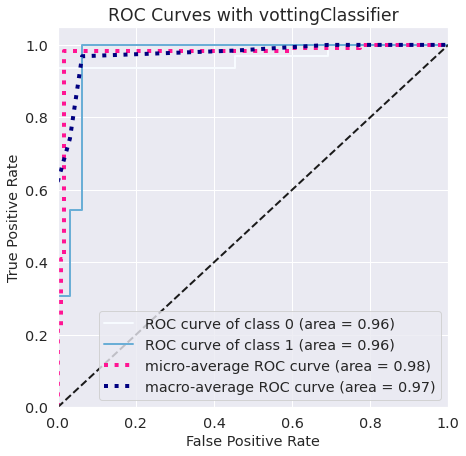

In [ ]:
skplt.metrics.plot_roc_curve(y_testsm,probas,title="ROC Curves with vottingClassifier", cmap='Blues', figsize=[7,7])
plt.show()

In [ ]:
report_with_auc = class_report(
    y_true=y_testsm, 
    y_pred=clf4.predict(np.array(test_out)), 
    y_score=clf4.predict_proba(np.array(test_out)))
print(" Voting classifier\n",report_with_auc)

 Voting classifier
              precision    recall  f1-score  support   pred       AUC
0             1.000000  0.937500  0.967742     32.0   30.0  0.964134
1             0.977778  1.000000  0.988764     88.0   90.0  0.964134
avg / total   0.983704  0.983333  0.983158    120.0  120.0  0.964134


In [ ]:
#y_pred = model.predict([facex_test,eegx_test])

In [ ]:
#cms = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#clr = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=event_id.keys())

#plt.figure(figsize=(8, 8))
#sns.heatmap(cms, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
# plt.xticks(np.arange(3) + 0.5, event_id.keys())
# plt.yticks(np.arange(3) + 0.5, event_id.keys())
#plt.xlabel("Predicted")
#plt.ylabel("Actual")
#plt.title("Confusion Matrix")
#plt.show()

#print("Classification Report:\n----------------------\n", clr)
#print("Accuracy score of Valence ")
#print(accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))*100)

# from sklearn.metrics import roc_curve, auc
# y_pred = np.array(list(map(lambda x: np.argmax(x), clf.predict(X_test))))
# print(y_pred.shape)
# print(y_test.shape)
# print(X_test.shape)


# fpr_keras_svm, tpr_keras_svm, thresholds_keras_svm = roc_curve(y_test, y_pred)
# auc_keras_svm = auc(fpr_keras_svm, tpr_keras_svm)
# auc_keras_svm = auc(fpr_keras_svm, tpr_keras_svm)

In [ ]:
# summarize history for accuracy
#plt.plot(history.history['accuracy'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train'], loc='upper left')
#plt.show()